In [1]:
import zipfile
import os
import cv2
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/MyDrive/archive.zip

def read_data(folder):
    data, label, paths = [], [], []

    for l in labels:
        path = f"{folder}/{l}/"

        folder_data = os.listdir(path)
        for image_path in folder_data:

            img = cv2.imread(path + image_path)
            data.append(img)
            label.append(l)

            paths.append(os.path.join(directory, l, image_path))

    return data, label, paths

directory = "/content/pc_parts"
labels= ["cables","case","cpu","gpu","hdd","headset","keyboard","microphone","monitor","motherboard","mouse","ram","speakers","webcam"]
all_data, all_labels, all_paths = read_data(directory)


print(f"Total images read: {len(all_data)}")



Mounted at /content/drive
Archive:  /content/drive/MyDrive/archive.zip
  inflating: pc_parts/cables/1.jpg   
  inflating: pc_parts/cables/10.jpg  
  inflating: pc_parts/cables/100.jpg  
  inflating: pc_parts/cables/101.jpg  
  inflating: pc_parts/cables/102.jpg  
  inflating: pc_parts/cables/103.jpg  
  inflating: pc_parts/cables/104.jpg  
  inflating: pc_parts/cables/105.jpg  
  inflating: pc_parts/cables/106.jpg  
  inflating: pc_parts/cables/107.jpg  
  inflating: pc_parts/cables/108.jpg  
  inflating: pc_parts/cables/109.jpg  
  inflating: pc_parts/cables/11.jpg  
  inflating: pc_parts/cables/110.jpg  
  inflating: pc_parts/cables/111.jpg  
  inflating: pc_parts/cables/112.jpg  
  inflating: pc_parts/cables/113.jpg  
  inflating: pc_parts/cables/114.jpg  
  inflating: pc_parts/cables/115.jpg  
  inflating: pc_parts/cables/116.jpg  
  inflating: pc_parts/cables/117.jpg  
  inflating: pc_parts/cables/118.jpg  
  inflating: pc_parts/cables/119.jpg  
  inflating: pc_parts/cables/12.jpg

> splitting datasets

In [2]:
import pandas as pd
df = pd.DataFrame({
    'image': all_data,
    'path': all_paths,
    'label': all_labels
})

In [3]:
from sklearn.model_selection import train_test_split


train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=123, shuffle=True, stratify=df['label'])
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=123, shuffle=True, stratify=dummy_df["label"])

print("Train dataset: ", len(train_df), "Test dataset: ", len(test_df), "Validation dataset: ", len(valid_df))
train_balance = train_df['label'].value_counts()

print('Train dataset value count: \n', train_df['label'].value_counts())


Train dataset:  2623 Test dataset:  328 Validation dataset:  328
Train dataset value count: 
 label
cables         238
speakers       237
case           225
keyboard       214
headset        211
hdd            210
monitor        205
motherboard    193
ram            181
microphone     171
mouse          168
webcam         131
gpu            125
cpu            114
Name: count, dtype: int64


Imbalance in the images classes

In [4]:
import plotly.express as px
px.histogram(train_df,x='label',barmode='group')

In [5]:
import numpy as np
def apply_transform(image):

  # Rotate (random angle between -40 and 40 degrees)
  angle = np.random.uniform(-40, 40)
  rows, cols = image.shape[:2]

  # Get rotation matrix
  M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)

  # Apply affine transformation
  image = cv2.warpAffine(image, M, (cols, rows))

  # Horizontal Flip
  if np.random.rand() < 0.5:
    image = cv2.flip(image, 1)

  # Vertical Flip
  if np.random.rand() < 0.5:
    image = cv2.flip(image, 0)

  # Random Brightness and Contrast
  # Brightness
  alpha = 1.0 + np.random.uniform(-0.2, 0.2)
  # Contrast
  beta = 0.0 + np.random.uniform(-0.2, 0.2)

  # Apply contrast and brightness scaling
  image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

  # Random Gamma Correction
  gamma = np.random.uniform(0.8, 1.2)
  # Apply gamma correction
  image = np.clip((image / 255.0) ** gamma, 0, 1) * 255.0

  return image


> AUGMENTATION


In [6]:
def apply_augmentation(image_path, label):
  """Applies random augmentation to an image.

  Args:
      image_path: Path to the image file.
      label: The label of the image.

  Returns:
      A tuple containing the augmented image and the label.
  """

  image = cv2.imread(image_path)  # Read the image

  # Apply random horizontal flip
  if np.random.rand() < 0.5:
    image = cv2.flip(image, 1)

  # Apply random vertical flip
  if np.random.rand() < 0.5:
    image = cv2.flip(image, 0)

  # Convert the image to RGB color space (if needed)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image, label


In [7]:
augmented_data = []
for index, row in train_df.iterrows():
    image_path = row['path']
    label = row['label']

    augmented_image, augmented_label = apply_augmentation(image_path, label)
    augmented_data.append((augmented_image, augmented_label, image_path))

augmented_df = pd.DataFrame(augmented_data, columns=['object', 'label', 'path'])

merged_df = pd.concat([train_df, augmented_df], ignore_index=True)


In [8]:
from collections import Counter
class_counts = Counter (merged_df ['label'])
min_class_count = min(class_counts.values())

balanced_data = []
for label, count in class_counts.items():
  class_samples = merged_df[merged_df['label'] == label].sample(min_class_count)
  balanced_data.append(class_samples)

balanced_df = pd.concat(balanced_data)

balanced_df['label'].value_counts()

label
mouse          228
keyboard       228
motherboard    228
cpu            228
microphone     228
webcam         228
hdd            228
monitor        228
cables         228
ram            228
gpu            228
case           228
headset        228
speakers       228
Name: count, dtype: int64

In [9]:
!pip install tensorflow
!pip install keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rescale=1./255)


In [10]:
gen = ImageDataGenerator(rescale=1./255)

train_gen = gen.flow_from_dataframe(
    balanced_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=32
)

val_gen = gen.flow_from_dataframe(
    valid_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=32
)

test_gen = gen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    seed=123,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=32
)

# Get the number of classes
num_classes = len(train_gen.class_indices)

Found 3192 validated image filenames belonging to 14 classes.
Found 328 validated image filenames belonging to 14 classes.
Found 328 validated image filenames belonging to 14 classes.


In [11]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import tensorflow as tf

In [12]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_gen, validation_data=val_gen, batch_size=42, epochs=20, verbose=1)

Epoch 1/20
100/100 [==============================] - 35s 252ms/step - loss: 1.8774 - accuracy: 0.4352 - val_loss: 1.4381 - val_accuracy: 0.6006
Epoch 2/20
100/100 [==============================] - 16s 159ms/step - loss: 1.2574 - accuracy: 0.6306 - val_loss: 1.2408 - val_accuracy: 0.6585
Epoch 3/20
100/100 [==============================] - 16s 161ms/step - loss: 1.0763 - accuracy: 0.6776 - val_loss: 1.2483 - val_accuracy: 0.6524
Epoch 4/20
100/100 [==============================] - 17s 166ms/step - loss: 0.9580 - accuracy: 0.7159 - val_loss: 1.2418 - val_accuracy: 0.6280
Epoch 5/20
100/100 [==============================] - 17s 169ms/step - loss: 0.8866 - accuracy: 0.7315 - val_loss: 1.2039 - val_accuracy: 0.6646
Epoch 6/20
100/100 [==============================] - 18s 176ms/step - loss: 0.8011 - accuracy: 0.7704 - val_loss: 1.3294 - val_accuracy: 0.6159
Epoch 7/20
100/100 [==============================] - 18s 176ms/step - loss: 0.7580 - accuracy: 0.7747 - val_loss: 1.2367 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



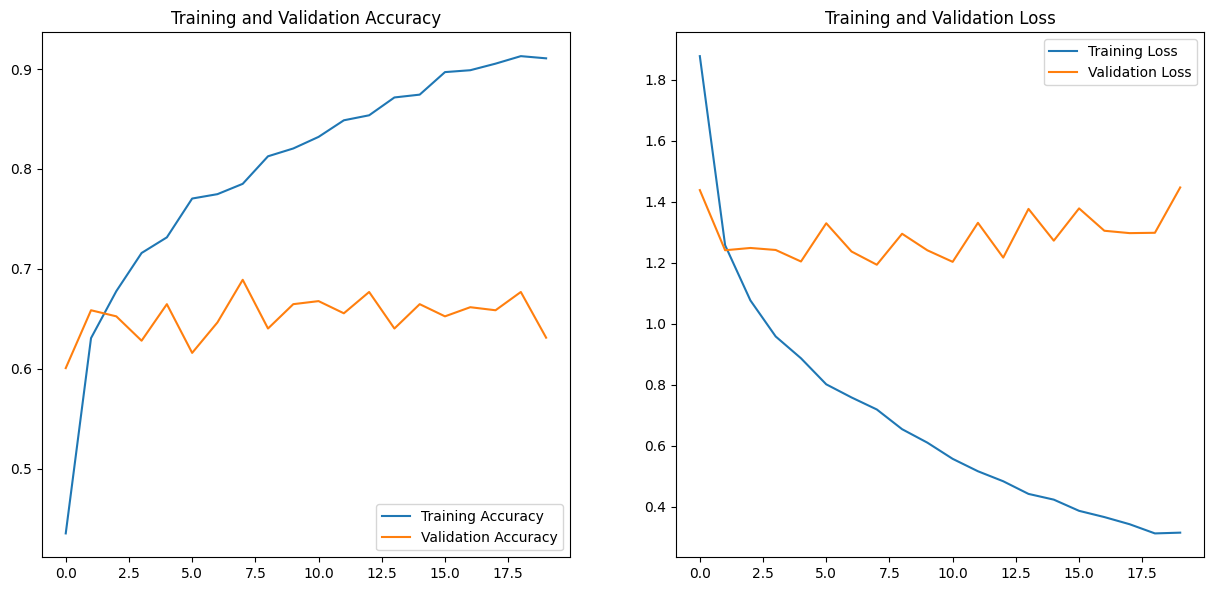

In [14]:
model.save('vgg19_model.h5')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



> FIG-1: training accurracy is increasing constantly, which means model is learning good but validation accurracy is too low and uneven which indicate model is overfitting

> FIG 2: seems like model overfitted

> Note: the same happened for many different parameters as we did hyperparameter tuning , it meant model might be complex for given dataset

In [15]:
# Define predictor function
def predictor(model, test_gen):
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    predictions = model.predict(test_gen, verbose=1)
    errors = 0
    pred_indices = []
    test_count = len(predictions)

    for i, p in enumerate(predictions):
        pred_index = np.argmax(p)
        pred_indices.append(pred_index)
        true_index = test_gen.labels[i]
        if pred_index != true_index:
            errors += 1

    accuracy = (test_count - errors) * 100 / test_count
    ytrue = np.array(test_gen.labels, dtype='int')
    ypred = np.array(pred_indices, dtype='int')
    msg = f"There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f}"
    print(msg)

    cm = confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    clr = classification_report(ytrue, ypred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)
    return

In [16]:
from tensorflow.keras.preprocessing import image

labels.sort()

labels

['cables',
 'case',
 'cpu',
 'gpu',
 'hdd',
 'headset',
 'keyboard',
 'microphone',
 'monitor',
 'motherboard',
 'mouse',
 'ram',
 'speakers',
 'webcam']

def get_model_prediction(image_path):
    img = image.load_img(image_path, target_size=(224,224,3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x, verbose=0)
    return labels[predictions.argmax()]

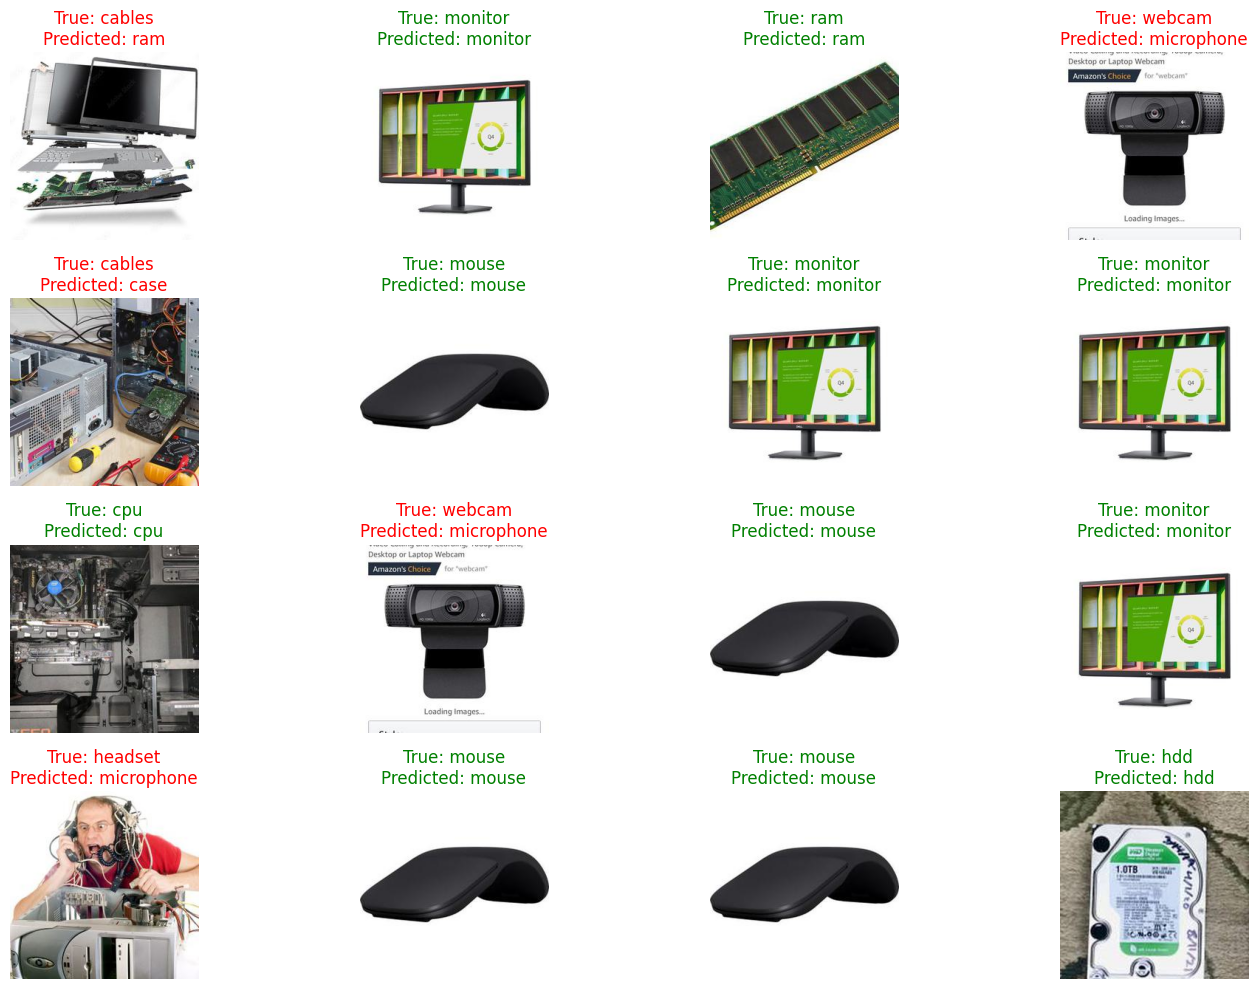

In [17]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np

pred = []
for file in test_df['path'].values:
    pred.append(get_model_prediction(file))

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))
random_index = np.random.randint(0, len(test_gen), 16)

for i, ax in enumerate(axes.ravel()):
    img_path = test_df['path'].iloc[random_index[i]]
    ax.imshow(load_img(img_path))
    ax.axis("off")
    if test_df['label'].iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df['label'].iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)

plt.tight_layout()
plt.show()